Summary:

In this notebook, I tried to build a model that can predict the profit of an order based on the order's sub-category, the sales number, quantity and the discound applied.

To train the model:

First I loaded the data and only kept the features we wish to use. This makes sure that only the most relevant features are used, and model will not overfit

The data is then seperated into X for the features we wish to make prediction on, and y, the label being the profit.

One-hot encoding is used to represent categorical data (sub-categories) in numbers. This create a new column for each sub-category and assign 1 if it is the correct sub-category for that order, and 0 otherwise.

Then I used train_test_split to split 70% of the data for training, and leave 30% of the data for testing the model.

For values such as Sales and Quantity, the Standard Scaler is used so that the all of the data will have around the same range. 

The ridge linear regression model is selected, based on its ability to perform regularization in order to avoid overfitting due to small sample size.


For the performance of the model, I measured for the test set:

mean squared error = 15962.499245435818

root mean squared error = 126.34278469875444

mean absolute error = 59.75847115904667

mean absolute percentage error = 3380970863445302.5

symmetric mean absolute percentage error = 114.20676879540575

R^2 score = 0.2646257853785624, where 26.5% of the variation in profit around the mean profit is explained by this model.

A graph of cumulative profit based on the last 100 order is made, this shows the prediction of the model compared to true value.


The coefficient of the model are:

[  26.87143039   -0.95140864 -312.10113596  -17.55271946   33.42174841  -35.31839414   19.4493652 ]

['Sales', 'Quantity', 'Discount', 'is_Bookcases', 'is_Chairs', 'is_Tables', 'is_Furnishings']

This means that sales have a positive correlation with profit, quantity have little to no correlation.

Discount on the other hand is very much negatively correlated with profit

Chairs and furnishings will add to the profit, while bookcases and tables will lead to negative profit.


\
One problem with this model is that the relationship between our features and our label is not linear. For example, a discount of 10% on a sale of 5000 can lead to more loss in profit than a discount of 50% on a sale of 100, even though we have a larger discount in the second case.

Using non-linear models such as neural networks, or decision trees can capture these relationships not properly represented.

Another way is to engineer additional non-linear features, such as the (discount * sales), or (quantity * is_sub-category) for better capture of non-linear relationship with the model.

We can also improve the model by trying different hyperparameters, such as using GridSearch for different values of regularization alpha terms. This should hopefully produce a model with less errors.

In [272]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [273]:
#Load data
sales = pd.read_csv('store_sales.csv', encoding = 'latin-1')

#Print top 10
sales.iloc[0:10]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
5,24,US-2017-156909,7/16/2017,7/18/2017,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,...,19140,East,FUR-CH-10002774,Furniture,Chairs,"Global Deluxe Stacking Chair, Gray",71.3720,2,0.30,-1.0196
6,25,CA-2015-106320,9/25/2015,9/30/2015,Standard Class,EB-13870,Emily Burns,Consumer,United States,Orem,...,84057,West,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,1044.6300,3,0.00,240.2649
7,28,US-2015-150630,9/17/2015,9/21/2015,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.4300,7,0.50,-1665.0522
8,30,US-2015-150630,9/17/2015,9/21/2015,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-FU-10004848,Furniture,Furnishings,"Howard Miller 13-3/4"" Diameter Brushed Chrome ...",124.2000,3,0.20,15.5250
9,37,CA-2016-117590,12/8/2016,12/10/2016,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",190.9200,5,0.60,-147.9630


In [275]:
sales.info()
#No value missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

The dataset consists of 2121 entries, each with 21 variables.
This datasets describes the orders completed by a furniture store, with date ranging between 2014 to 2018.

The data collected includes: What the order is about (Order ID, product ID and its categories and sub-categories), names of customers, and addresses of customers, all in the US. It also includes the sale price, quantity of products, discount applied (between 0 and 1) and profit made.

The goal of this project is to be able to train a machine learning model that can predict the profits of an order, using information such as sales, quantity, sub-category of product and discount applied.

In [276]:
#Drop irrelevant columns. Information that is too specific may lead to overfitting and cannot generalize beyond existing customers. We want a general model.
sales = sales[['Sub-Category','Sales','Quantity','Discount','Profit']]


In [277]:
#Create one-hot encodings to represent each sub-category

#Loop for every sub-category
for i in sales['Sub-Category'].unique():
    #Check for all rows if the mode is correct for the current sub-category, write as 1 if equal, 0 otherwise
    sales[f'is_{i}'] = (sales['Sub-Category'] == i).astype(int)

#Drop the original column.
sales.drop(['Sub-Category'],axis=1, inplace=True)

In [278]:
sales

,Sales,Quantity,Discount,Profit,is_Bookcases,is_Chairs,is_Tables,is_Furnishings
0,261.9600,2,0.00,41.9136,1,0,0,0
1,731.9400,3,0.00,219.5820,0,1,0,0
2,957.5775,5,0.45,-383.0310,0,0,1,0
3,48.8600,7,0.00,14.1694,0,0,0,1
4,1706.1840,9,0.20,85.3092,0,0,1,0
...,...,...,...,...,...,...,...,...
2116,383.4656,4,0.32,-67.6704,1,0,0,0
2117,13.4000,1,0.00,6.4320,0,0,0,1
2118,85.9800,1,0.00,22.3548,0,0,1,0
2119,25.2480,3,0.20,4.1028,0,0,0,1


In [279]:
#train_test_split on data to create training and validation sets.
#The profit is the label, everything else are features
y = sales['Profit']
X = sales[['Sales','Quantity','Discount','is_Bookcases','is_Chairs','is_Tables','is_Furnishings']]

#Split the data into training and testing sets, 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101 )


In [280]:
#Create a function that standardizes the sales and quantity number
def standardizer(X_numerical, X_categorical):
    #Reset the index for both dataframes
    X_numerical = X_numerical.reset_index(drop=True)
    X_categorical = X_categorical.reset_index(drop=True)
    #Set the scaler
    scaler = StandardScaler()
    #Scale the numerical data
    X_scaled = pd.DataFrame(scaler.fit_transform(X_numerical), columns=list(X_numerical))
    #Combine the two data
    X_combined = pd.concat([X_scaled, X_categorical], axis=1)
    
    return X_combined

In [281]:
#This selects the columns of values which should be standardized
X_train_numerical = X_train[['Sales','Quantity']]
X_test_numerical = X_test[['Sales','Quantity']]
#Scale these data using standard scaler to make sure data are in the same range
#pd.DataFrame is used to turn it back into a dataframe.
X_train = standardizer(X_train_numerical, X_train[['Discount','is_Bookcases','is_Chairs','is_Tables','is_Furnishings']])
X_test = standardizer(X_test_numerical, X_test[['Discount','is_Bookcases','is_Chairs','is_Tables','is_Furnishings']])


For the model, A linear regression model is used. This is because I am assuming a linear relationship between the features and the profit. In this case, I chose Ridge regression since it also included a regularization term, which should be helpful in preventing overfit of the model to the data.

In [283]:
#Set the model
model = Ridge(random_state=101)

#train the model
model.fit(X_train, y_train)

#Test the model by predicting using the test set
y_pred = model.predict(X_test)

In [167]:
#Create the metric missing from Scikit-learn
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    #Uses the formula to calculate smape
    return 100/len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [284]:
#Compare model performance using test data
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#Measures the average of sum of square errors. The average of the differences squared. This means differences further from the mean gives larger errors.
print(f'mean squared error = {mse}')
#Root of MSE, more interpretable than MSE since it is in the same units as the data
print(f'root mean squared error = {rmse}')
#Measures the mean absolute difference between prediction and true. Straightforward way of giving average of how wrong we are. Errors are weighted equally.
print(f'mean absolute error = {mae}')
#The average percentage difference of the prediction vs true.
#In this case, it is arbitrarily large since true profit can be around 0, where any error will give percentage approaching infinity.
print(f'mean absolute percentage error = {mape}')
#This fixes the problem of mape by taking a percentage error using the mid point between true and predicted value instead.
print(f'symmetric mean absolute percentage error = {smape}')

#This value calculates the percentage of variation we have explained using our model, compared to the variation around the mean profit.
print(f'R^2 score = {r2}')

mean squared error = 15962.499245435818
root mean squared error = 126.34278469875444
mean absolute error = 59.75847115904667
mean absolute percentage error = 3380970863445302.5
symmetric mean absolute percentage error = 114.20676879540575
R^2 score = 0.2646257853785624


In [285]:
#Comparing training and testing set:
#Find metric for test instead.
mse_train = mean_squared_error(y_train, model.predict(X_train))
rmse_train = root_mean_squared_error(y_train, model.predict(X_train))
mae_train = mean_absolute_error(y_train, model.predict(X_train))
mape_train = mean_absolute_percentage_error(y_train, model.predict(X_train))
smape_train = symmetric_mean_absolute_percentage_error(y_train, model.predict(X_train))
r2_train = r2_score(y_train, model.predict(X_train))

print(f'Training mean squared error = {mse_train}')
print(f'Training root mean squared error = {rmse_train}')
print(f'Training mean absolute error = {mae_train}')
print(f'Training mean absolute percentage error = {mape_train}')
print(f'Training symmetric mean absolute percentage error = {smape_train}')

print(f'Training R^2 score = {r2_train}')

Training mean squared error = 11947.621438148695
Training root mean squared error = 109.3051757152821
Training mean absolute error = 60.555305581575915
Training mean absolute percentage error = 1570884798333092.5
Training symmetric mean absolute percentage error = 115.4979429714487
Training R^2 score = 0.30229060575553357


C:\ProgramData\Temp\ipykernel_13148\429395882.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_2.drop(['Profit'], axis=1, inplace=True)


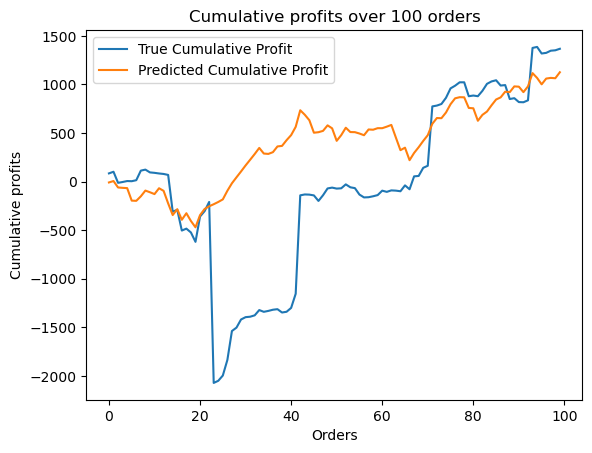

In [286]:
#Predicting cumulative profit for the last 100 orders (Bad comparison, since model is trained using datapoints from within the test set)

#Find the true cumulative profit for last 100 orders
y_true = sales['Profit'].iloc[-100:].cumsum()

#Create the test set using last 100 orders
X_test_2 = sales.iloc[-100:]
#Drop the label we're trying to predict
X_test_2.drop(['Profit'], axis=1, inplace=True)

#Standardize the data for input
X_test_2_numerical = X_test_2[['Sales','Quantity']]
X_test_2 = standardizer(X_test_2_numerical, X_test_2[['Discount','is_Bookcases','is_Chairs','is_Tables','is_Furnishings']])


#Perform prediction
y_pred_2 = model.predict(X_test_2)
#Find the cumulative profit of prediction
y_pred_2 = y_pred_2.cumsum()

#print(sales.iloc[-100:])

#Plot the two cumulative profits
plt.plot(range(100),y_true, label='True Cumulative Profit')
plt.plot(range(100),y_pred_2, label='Predicted Cumulative Profit')

#Label
plt.legend()
plt.xlabel('Orders')
plt.ylabel('Cumulative profits')
plt.title('Cumulative profits over 100 orders')
plt.show()

In [287]:
#Print the coefficients of the model
print(model.coef_)
print(list(X_train))

[  26.87143039   -0.95140864 -312.10113596  -17.55271946   33.42174841
  -35.31839414   19.4493652 ]
['Sales', 'Quantity', 'Discount', 'is_Bookcases', 'is_Chairs', 'is_Tables', 'is_Furnishings']
